In [50]:
# Import libraries
%matplotlib inline
from IPython.display import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, label_binarize
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [2]:
# Save the DataFrame created to a csv file
data = "/Users/florencialeoni/code/omg_i_love_that_song/data/df_for_modeling.csv"

In [3]:
# Create DataFrame
df = pd.DataFrame.from_csv(data)

In [4]:
# Check DataFrame
df.head()

key  mode  time_signature  acousticness  energy  instrumentalness  \
0  4.0   0.0             4.0       0.03110   0.813          0.006970   
1  5.0   0.0             4.0       0.02490   0.838          0.025000   
2  2.0   0.0             4.0       0.00238   0.758          0.000000   
3  4.0   0.0             4.0       0.20200   0.714          0.000234   
4  0.0   1.0             4.0       0.05610   0.606          0.000000   

   liveness  loudness  speechiness  valence    tempo  release_date  \
0    0.0471    -7.105       0.1210    0.810  125.461          2005   
1    0.2420    -3.914       0.1140    0.924  143.040          2003   
2    0.0598    -6.583       0.2100    0.701   99.259          2003   
3    0.0521    -6.055       0.1400    0.818  100.972          2002   
4    0.3130    -4.596       0.0713    0.654   94.759          2000   

   popularity  song_duration  danceability  
0        65.0           3.78             1  
1        78.0           3.31             1  
2        58.0           3.93             0  
3        72.0           4.45             1  
4        17.0           3.79             1

In [5]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265335 entries, 0 to 266382
Data columns (total 15 columns):
key                 265335 non-null float64
mode                265335 non-null float64
time_signature      265335 non-null float64
acousticness        265335 non-null float64
energy              265335 non-null float64
instrumentalness    265335 non-null float64
liveness            265335 non-null float64
loudness            265335 non-null float64
speechiness         265335 non-null float64
valence             265335 non-null float64
tempo               265335 non-null float64
release_date        265335 non-null int64
popularity          265335 non-null float64
song_duration       265335 non-null float64
danceability        265335 non-null int64
dtypes: float64(13), int64(2)
memory usage: 32.4 MB


# Features and Target 

In [6]:
target = df["danceability"]
features = df[["key", "mode", "time_signature", "acousticness", "energy", "instrumentalness", "liveness", 
               "loudness", "speechiness", "valence", "tempo", "release_date", "popularity", "song_duration"]]

# Feature Engineering & Transformations

In [7]:
# Creating Polynomial Features
poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(features)
column_names = poly.get_feature_names(features.columns)
poly_features = pd.DataFrame(poly.transform(features), columns = column_names)

In [8]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(poly_features, target, random_state = 40, test_size = 0.2)

In [12]:
# Select best columns using F1 score method from sklearn
selector = SelectKBest(f_regression, k = 30)
selector.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function f_regression at 0x1a19e746a8>)

In [13]:
# Remove non-selected columns
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [14]:
# Sanity Check
X_train.shape

(212268, 30)

# Dataset Resampling

In [51]:
# Non-train-test-split features and target for XGBoost K-Fold Cross Validation Model
selector_1 = SelectKBest(f_regression, k = 30)
selector_1.fit(poly_features, target)

SelectKBest(k=30, score_func=<function f_regression at 0x1a19e746a8>)

In [52]:
# Remove non-selected columns
selected_columns = poly_features.columns[selector_1.get_support()]
removed_columns = poly_features.columns[~selector_1.get_support()]
X = poly_features[selected_columns]
Y = target

In [53]:
X.isnull().any()

time_signature                   False
energy                           False
loudness                         False
valence                          False
key valence                      False
time_signature^2                 False
time_signature energy            False
time_signature loudness          False
time_signature valence           False
time_signature release_date      False
acousticness^2                   False
acousticness instrumentalness    False
acousticness loudness            False
acousticness song_duration       False
energy valence                   False
energy release_date              False
instrumentalness loudness        False
loudness^2                       False
loudness valence                 False
loudness tempo                   False
loudness release_date            False
loudness song_duration           False
valence^2                        False
valence tempo                    False
valence release_date             False
valence popularity       

In [72]:
# Create Shuffle Split object
shuffle = ShuffleSplit(n_splits = 10, test_size = 7000, train_size = 20000, random_state = 40)

In [73]:
# Generate indices to data splits 
for train_index, test_index in shuffle.split(X, Y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

In [84]:
# Sanity Check
Xtrain.shape

(20000, 30)

# Dummy Classifier: Baseline Model

In [20]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy = "most_frequent").fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [21]:
# checking accuracy
print("Test Accuracy score: ", accuracy_score(y_test, dummy_pred))
print("Test F1 score: ", f1_score(y_test, dummy_pred, average = "micro"))

Test Accuracy score:  0.45553733958957543
Test F1 score:  0.45553733958957543


# Fit Model 1: Logistic Regression

In [25]:
# Create LogisticRegression
log_reg = linear_model.LogisticRegression(random_state = 40, multi_class = "multinomial")

In [27]:
# Create regularization term space
lambda_terms = [0.1, 0.01, 0.001, 0.45, 1.30, 3.75]

# Create solver parameters
solver_params = ["newton-cg", "sag", "saga", "lbfgs"]

# Create hyperparameters
hyperparameters = dict(C = lambda_terms, solver = solver_params)

In [33]:
# Create GridSearch
lg_gs = GridSearchCV(log_reg, hyperparameters, cv = 10, scoring = "f1_micro")

In [34]:
# Fit GridSearch
model_lr = lg_gs.fit(X_train, y_train)

In [35]:
# Model best estimators
print("Solver: ", model_lr.best_estimator_.get_params()["solver"])
print("Lambda: ", model_lr.best_estimator_.get_params()["C"])

Penalty:  newton-cg
Lambda:  0.45


In [45]:
# Predictions
y_train_pred = model_lr.best_estimator_.predict(X_train)
y_test_pred = model_lr.best_estimator_.predict(X_test)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(y_train, y_train_pred, average = "micro"))
print("Test F1 Micro Average: ", f1_score(y_test, y_test_pred, average = "micro"))

Training F1 Micro Average:  0.5776801025119189
Test F1 Micro Average:  0.5738406165790416


Model Coefficients


('valence^2', -0.40096722460107836)
('acousticness^2', -0.2750968429705744)
('energy valence', -0.2024622791673568)
('valence song_duration', -0.14650882750395686)
('acousticness instrumentalness', -0.12225342037719292)
('acousticness loudness', -0.07578989009577489)
('time_signature^2', 0.05549106368879112)
('time_signature valence', 0.051493521430360435)
('time_signature loudness', 0.03530696435937035)
('time_signature energy', 0.03477058693319531)
('time_signature', -0.023505975793047064)
('song_duration^2', -0.022037455684382406)
('loudness', -0.020353092778515013)
('energy', -0.017097489512350315)
('loudness song_duration', -0.013974270521668539)
('tempo', -0.012250268585350658)
('instrumentalness loudness', 0.00831582725026056)
('valence', 0.006520848477032326)
('acousticness song_duration', 0.0045935165368726)
('loudness valence', -0.0015980266099085445)
('valence tempo', 0.0013929281294837725)
('tempo song_duration', 0.0008650211835754069)
('energy release_

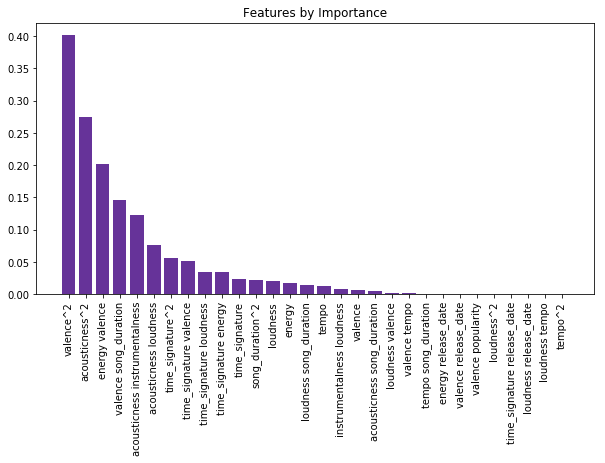

In [46]:
# Sort feature importances in descending order
coefficients = list(zip(X_train.columns, model_lr.best_estimator_.coef_[0]))
coefficients.sort(key = lambda x: abs(x[1]), reverse=True)

# Match feature names to sorted features
lr_features = [f[0] for f in coefficients]
feature_weights = [abs(f[1]) for f in coefficients]

# Print coefficients
print("Model Coefficients")
print("\n")
for coefficient in coefficients:
    print(coefficient)
print("---------------------------------------------")
print("\n")

# Plot features by importance
plt.figure()
plt.title("Features by Importance")
plt.bar(lr_features, feature_weights, color = "rebeccapurple")

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), lr_features, rotation=90)

# Show plot
plt.show()

[[17732  3984  2458]
 [ 8075  7326   434]
 [ 7035   629  5394]]


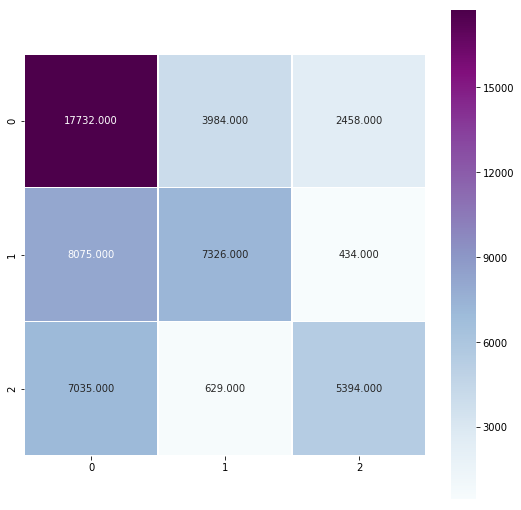

In [48]:
# Confusion Matrix
lr_cm = confusion_matrix(y_test, y_test_pred)
print(lr_cm)

plt.figure(figsize = (9, 9))
sns.heatmap(lr_cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

In [50]:
# Classification Report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62     24174
           1       0.61      0.46      0.53     15835
           2       0.65      0.41      0.51     13058

   micro avg       0.57      0.57      0.57     53067
   macro avg       0.60      0.54      0.55     53067
weighted avg       0.59      0.57      0.57     53067



# Fit Model 2: KNN

In [51]:
# Create KNN 
knn_model = KNeighborsClassifier()

In [75]:
# Number of neighbors
n_neighbors = range(3, 5, 10)

# Create regularization term space
weights = ["uniform", "distance"]

# Create distance metrics space
dist_metrics = [1, 2]

# Create hyperparameters
hyperparameters = dict(n_neighbors = n_neighbors, weights = weights, p = dist_metrics)

In [76]:
# Create GridSearch
knn_gs = GridSearchCV(knn_model, hyperparameters, cv = 5, scoring = "f1_micro")

In [77]:
# Fit GridSearch
model_knn = knn_gs.fit(X_train, y_train)

In [78]:
# Model best estimators
print("Number of Neighbors: ", model_knn.best_estimator_.get_params()["n_neighbors"])
print("Weighting Type: ", model_knn.best_estimator_.get_params()["weights"])
print("Distance Metric: ", model_knn.best_estimator_.get_params()["p"])

Number of Neighbors:  3
Weighting Type:  distance
Distance Metric:  1


In [79]:
# Predictions
y_train_pred_knn = model_knn.best_estimator_.predict(X_train)
y_test_pred_knn = model_knn.best_estimator_.predict(X_test)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(y_train, y_train_pred_knn, average = "micro"))
print("Test F1 Micro Average: ", f1_score(y_test, y_test_pred_knn, average = "micro"))

Training F1 Micro Average:  1.0
Test F1 Micro Average:  0.8748751578193604


[[21487  1439  1248]
 [ 1488 14000   347]
 [ 1684   434 10940]]


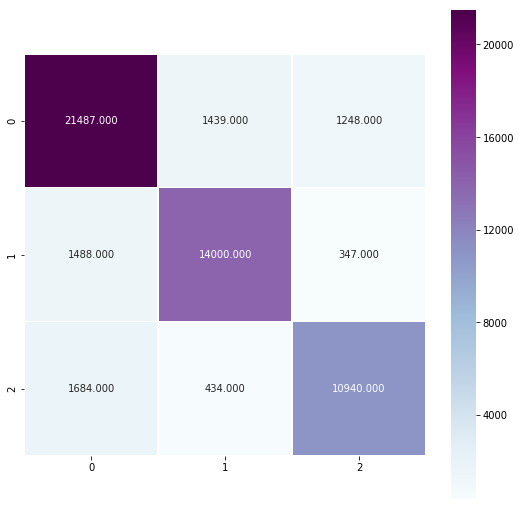

In [80]:
# Confusion Matrix
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
print(knn_cm)

plt.figure(figsize = (9, 9))
sns.heatmap(knn_cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")

In [81]:
# Classification Report
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24174
           1       0.88      0.88      0.88     15835
           2       0.87      0.84      0.85     13058

   micro avg       0.87      0.87      0.87     53067
   macro avg       0.88      0.87      0.87     53067
weighted avg       0.87      0.87      0.87     53067



# Fit Model 3: Decision Tree

In [83]:
# Create Decision Tree classifier
clf_tree = DecisionTreeClassifier(random_state = 40)

In [84]:
# Criterion for splitting
criterion = ["gini", "entropy"]

# The minimum number of samples required to be at a leaf node.
min_samples_leaf = range(1, 50, 10)

# Maximum tree depth
max_depth = range(2, 11, 2)

# Maximum features to consider at split
max_features = [0.2, 0.3, 0.5, 0.75, 0.80]

class_weights = ["balanced", None]

# Create hyperparameters
hyperparameters = dict(criterion = criterion, min_samples_leaf = min_samples_leaf, 
                       max_depth = max_depth, max_features = max_features, class_weight = class_weights)

In [85]:
# Create Grid Search
tree_gs = GridSearchCV(clf_tree, hyperparameters, cv = 10, verbose = 2)

In [86]:
# Fit Tree
model_tree = tree_gs.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=1, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=41, total=   0.3s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=31, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=

[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=2, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.6s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.6s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.6s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.7s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.6s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=4, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=21, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1, total=   1.6s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=1, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=41, total=   1.5s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31, total=   2.3s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=31, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21, total=   2.3s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21, total=   2.4s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=21, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=6, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.1s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.9s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.7s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.6s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.5s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.5s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.4s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.4s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   2.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   2.9s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   2.8s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.0s
[CV] class_weight=balanced, criterion=gini, max_depth=8, max_

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.3s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.4s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.0s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.8s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   2.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   2.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.2s
[CV] class_weight=balanced, criterion=gini,

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.1s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.3s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.7s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.6s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.3s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max

[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.2s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.6s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.6s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.5s
[CV] class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.7s
[CV] class_weight=balanced, criterion=gini, max_dept

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11, total=   0.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11, total=   0.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.4s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.7s
[CV] class_weight=balanced, criterion=e

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.9s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.9s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=11, total=   0.5s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=entro

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=31, total=   1.4s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=11, total=   1.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=21, total=   1.6s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=1, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=1, total=   1.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=11, total=   2.1s
[CV] class_weight=balanced, criterion

[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=1, total=   0.7s
[CV] class_weight=balanced, criterion=

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=41, total=   0.7s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.7s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   2.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   2.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   2.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   2.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   2.3s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   2.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   2.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   2.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   2.5s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   2.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   3.0s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=21, total=   0.9s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11, total=   1.4s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=11, total=   1.4s
[CV] class_weight=balanced, criteri

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1, total=   2.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1, total=   2.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=1, total=   2.0s
[CV] class_weight=balanced, criterion=en

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   2.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   2.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=41, total=   2.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=41, total=   2.0s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   3.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   3.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=31, total=   2.9s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.0s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.2s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.1s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.6s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   4.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   3.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   3.3s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   3.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   3.0s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.5s
[CV] class_weigh

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   3.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   3.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   4.2s
[CV] class_weight=balanced, 

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   3.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   3.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   3.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.7s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.7s
[CV] class_weight=balance

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.2s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=

[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=2, max_features=0.8, min_samples_leaf=41 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31, total=   0.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.2, min_samples_leaf=31 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.3, min_samples_leaf=21 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.5, min_samples_leaf=11 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.3s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.3s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=1, total=   1.3s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=11 
[CV]

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.75, min_samples_leaf=41, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=1, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=1 
[

[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41, total=   1.4s
[CV] class_weight=None, criterion=gini, max_depth=4, max_features=0.8, min_samples_leaf=41 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.2, min_samples_leaf=31 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.3, min_samples_leaf=21 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.3s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=11 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=1, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=11, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=11 
[C

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.75, min_samples_leaf=41, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=1, total=   2.0s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=1, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=1 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=31, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=6, max_features=0.8, min_samples_leaf=41 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.2, min_samples_leaf=31 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.3, min_samples_leaf=21 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11, total=   1.6s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11, total=   1.5s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11, total=   1.5s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11, total=   1.5s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=11, total=   1.6s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.5, min_samples_leaf=21 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=1, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=1, total=   2.3s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=1, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=11, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=11, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=11 


[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=41, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.75, min_samples_leaf=41, total=   2.2s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=1 
[CV]  cla

[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.5s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.4s
[CV] class_weight=None, criterion=gini, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV] 

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.2, min_samples_leaf

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.2s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.3, min_samples_leaf

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   1.9s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   1.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.5, min_samples_leaf

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   2.7s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_lea

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   2.7s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   2.6s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_sam

[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   2.9s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   2.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   2.9s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   2.8s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   2.9s
[CV] class_weight=None, criterion=gini, max_depth=10, max_features=0.8, min_samples_leaf

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.2, min_samples_leaf=31, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=11, total=   0.4s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.4s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.3, min_samples_leaf=21, total=   0.3s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=1, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=11, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.5, min_samples_leaf=41, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=1, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=31, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.75, min_samples_leaf=41, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_f

[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=21, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=2, max_features=0.8, min_samples_leaf=31, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=2, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.2, min_samples_leaf=21, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.3, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_s

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.5, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.75, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_f

[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21, total=   1.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21, total=   1.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21, total=   1.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21, total=   1.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=4, max_features=0.8, min_samples_leaf=21, total=   1.6s
[CV] class_weight=None, criterion=entropy, max_depth=4, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11, total=   0.7s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.2, min_samples_leaf=11, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=1, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_s

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.3, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31, total=   1.5s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31, total=   1.5s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31, total=   1.5s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.5, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21, total=   2.1s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21, total=   2.1s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21, total=   2.1s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21, total=   2.1s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.75, min_samples_leaf=21, total=   2.1s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_f

[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=6, max_features=0.8, min_samples_leaf=11, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=6, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=1, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=11, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.2, min_samples_leaf=41, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=1, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=31, total=   1.2s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=31, total=   1.2s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=31, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.3, min_samples_leaf=41, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=21, total=   1.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=21, total=   1.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.8s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.5, min_samples_leaf=31, total=   1.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=11, total=   2.6s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=11, total=   2.6s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.6s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.7s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.75, min_samples_leaf=21, total=   2.7s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_f

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=1, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=1, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   3.0s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=11, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8,

[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=8, max_features=0.8, min_samples_leaf=41, total=   2.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=1, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=31, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.2, min_samples_leaf=41, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=21, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.3s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.4s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.3, min_samples_leaf=31, total=   1.3s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   2.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=11, total=   2.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.3s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.5, min_samples_leaf=21, total=   2.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=1, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=11, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.75, min_samples_leaf=41, total=   3.2s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=1, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_fea

[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=31, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.4s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.5s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41 
[CV]  class_weight=None, criterion=entropy, max_depth=10, max_features=0.8, min_samples_leaf=41, total=   3.4s
[CV] class_weight=None, criterion=entropy, max_depth=10, max_

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed: 123.2min finished


In [87]:
# Model best estimators
print("Split Criterion: ", model_tree.best_estimator_.get_params()["criterion"])
print("Minimum Samples to Split: ", model_tree.best_estimator_.get_params()["min_samples_leaf"])
print("Max Depth: ", model_tree.best_estimator_.get_params()["max_depth"])
print("Max Features at Split: ", model_tree.best_estimator_.get_params()["max_features"])
print("Class Weights: ", model_tree.best_estimator_.get_params()["class_weight"])

Split Criterion:  gini
Minimum Samples to Split:  1
Max Depth:  10
Max Features at Split:  0.8
Class Weights:  None


In [89]:
# Predictions
y_train_pred_tree = model_tree.best_estimator_.predict(X_train)
y_test_pred_tree = model_tree.best_estimator_.predict(X_test)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(y_train, y_train_pred_tree, average = "micro"))
print("Test F1 Micro Average: ", f1_score(y_test, y_test_pred_tree, average = "micro"))

Training F1 Micro Average:  0.6765127103472968
Test F1 Micro Average:  0.6609380594343001


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.240451 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.240451 to fit



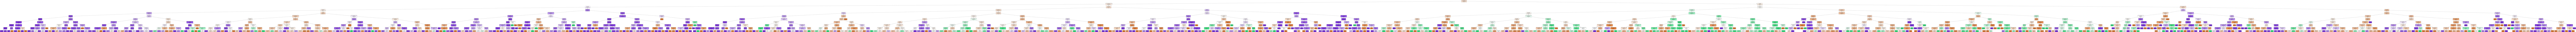

In [90]:
# Visualize Tree
dot_data = StringIO()
export_graphviz(model_tree.best_estimator_, out_file = dot_data,  
                filled = True, rounded = True, special_characters = True,
                feature_names = X_train.columns ,class_names = ["0", "1", "2"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Danceability_Tree.png')
Image(graph.create_png())

[[18608  3485  2081]
 [ 6165  9297   373]
 [ 5242   647  7169]]


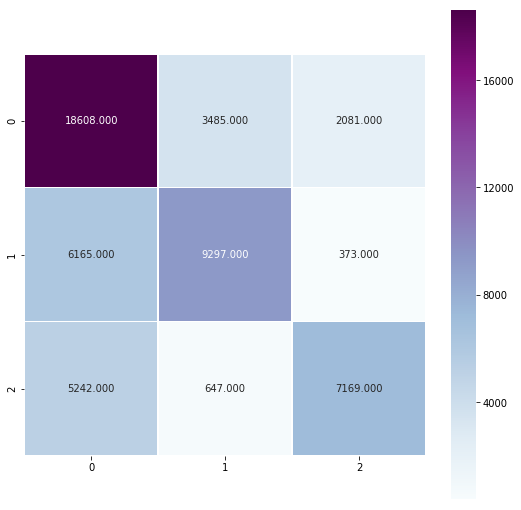

In [91]:
# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_test_pred_tree)
print(cm_tree)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_tree, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")

In [110]:
# Calculate feature importances
importances = model_tree.best_estimator_.feature_importances_

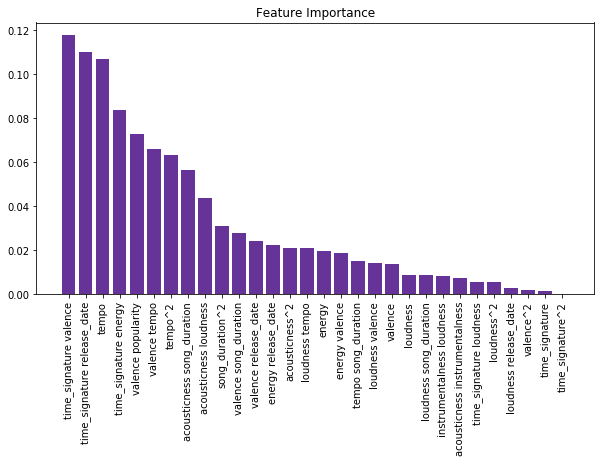

In [111]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices], color = "rebeccapurple")

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [99]:
# Classification Report
print(classification_report(y_test, y_test_pred_tree))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69     24174
           1       0.69      0.59      0.64     15835
           2       0.74      0.55      0.63     13058

   micro avg       0.66      0.66      0.66     53067
   macro avg       0.69      0.64      0.65     53067
weighted avg       0.67      0.66      0.66     53067



# Fit Model 4: Random Forest

In [38]:
# Create Randome Forest Classifier
rfc = RandomForestClassifier(random_state = 40)

In [39]:
# Number of trees in the forest
n_estimators = [100, 250]

# Criterion for splitting
criterion = ["gini", "entropy"]

# The minimum number of samples required to be at a leaf node.
min_samples_leaf = range(1, 100, 10)

# Maximum tree depth
max_depth = [5, 7, 10, 15]

# Maximum features to consider at split
max_features = [0.1, 0.25, 0.6, 0.75]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [40]:
# Create the parameters grid
random_grid = {"n_estimators": n_estimators,
               "criterion" : criterion,
               "max_depth": max_depth,
               "min_samples_leaf": min_samples_leaf,
               "max_features": max_features,
               "bootstrap": bootstrap}

In [41]:
# Random search of parameters, using 5 fold cross validation, 
# Search across 100 different combinations, and use all available cores
rfc_rs = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, 
                   verbose = 4, n_jobs = -1)

In [42]:
# Fit the model
model_forest = rfc_rs.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 89.5min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 189.4min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 362.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 464.5min finished


In [43]:
# Model best estimators
print("Split Criterion: ", model_forest.best_estimator_.get_params()["criterion"])
print("Minimum Samples to Split: ", model_forest.best_estimator_.get_params()["min_samples_leaf"])
print("Max Depth: ", model_forest.best_estimator_.get_params()["max_depth"])
print("Number of trees in the forest: ", model_forest.best_estimator_.get_params()["n_estimators"])
print("Max Features at Split: ", model_forest.best_estimator_.get_params()["max_features"])
print("Used Bootstraping: ", model_forest.best_estimator_.get_params()["bootstrap"])

Split Criterion:  gini
Minimum Samples to Split:  1
Max Depth:  15
Number of trees in the forest:  250
Max Features at Split:  0.1
Used Bootstraping:  True


In [44]:
# Predictions
y_train_pred_forest = model_forest.best_estimator_.predict(Xtrain)
y_test_pred_forest = model_forest.best_estimator_.predict(Xtest)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(Ytrain, y_train_pred_forest, average = "micro"))
print("Test F1 Micro Average: ", f1_score(Ytest, y_test_pred_forest, average = "micro"))

Training F1 Micro Average:  0.8871615128045679
Test F1 Micro Average:  0.8372268274302939


[[556  29  22]
 [ 80 308   3]
 [ 73   9 247]]


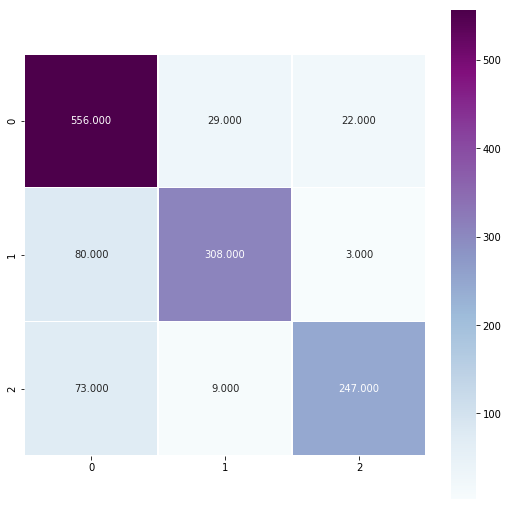

In [46]:
# Confusion Matrix
cm_rfc = confusion_matrix(Ytest, y_test_pred_forest)
print(cm_rfc)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_rfc, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

In [47]:
# Classification Report
print(classification_report(Ytest, y_test_pred_forest))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       607
           1       0.89      0.79      0.84       391
           2       0.91      0.75      0.82       329

   micro avg       0.84      0.84      0.84      1327
   macro avg       0.86      0.82      0.83      1327
weighted avg       0.85      0.84      0.84      1327



# Fit Model 5: XGBoost

In [18]:
# Create XGBoost Classifier
xg_clf = xgb.XGBClassifier(objective = "multi:softmax", n_estimators = 300, verbosity = True, 
                           eval_metric = ["merror", "map", "auc"])

In [19]:
# A parameter grid for XGBoost
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.5, 1, 1.5, 2, 5],
               "max_depth": [4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.4, 0.5, 0.7],
               "reg_alpha": [1, 5, 7]}

In [20]:
xg_rs = RandomizedSearchCV(xg_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 7, verbose = 3, random_state = 40 )

In [21]:
# Fit the model
model_xgboost = xg_rs.fit(Xtrain, Ytrain)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5910439886565984, total= 4.8min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s


[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5915446511014378, total= 4.9min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.9min remaining:    0.0s


[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5943147342039309, total= 4.8min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5857076902783274, total= 4.5min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5944796201028888, total= 4.4min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.5919598984269366, total= 4.8min
[CV] subsample=0.4, reg_alpha=1, max_depth=4, learning_rate=0.001, gamma=1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=1, max_depth=4, learn

[CV]  subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0, score=0.7224310776942355, total= 4.9min
[CV] subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0, score=0.7119773117003034, total= 4.8min
[CV] subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0, score=0.7236842105263158, total= 4.8min
[CV] subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0, score=0.7197836625663687, total= 4.7min
[CV] subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_alpha=7, max_depth=4, learning_rate=0.1, ga

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 418.8min finished


In [22]:
# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])

Learning Rate:  0.1
Gamma:  5
Max Depth:  7
Subsample:  0.5
Max Features at Split:  1.0
Alpha:  7


In [23]:
# Predictions
y_train_pred_xgboost = model_xgboost.predict(Xtrain)
y_test_pred_xgboost = model_xgboost.predict(Xtest)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(Ytrain, y_train_pred_xgboost, average = "micro"))
print("Test F1 Micro Average: ", f1_score(Ytest, y_test_pred_xgboost, average = "micro"))
print("Test Accuracy: ", accuracy_score(Ytest, y_test_pred_xgboost))

Training F1 Micro Average:  0.8138862193076678
Test F1 Micro Average:  0.7935192162773171
Test Accuracy:  0.7935192162773173


[[509  54  44]
 [ 86 302   3]
 [ 79   8 242]]


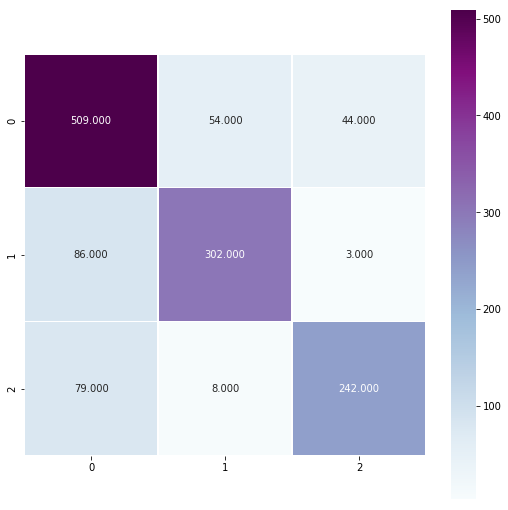

In [48]:
# Confusion Matrix
cm_xgboost = confusion_matrix(Ytest, y_test_pred_xgboost)
print(cm_xgboost)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_xgboost, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

In [29]:
# Classification Report
print(classification_report(Ytest, y_test_pred_xgboost))

              precision    recall  f1-score   support

           0       0.76      0.84      0.79       607
           1       0.83      0.77      0.80       391
           2       0.84      0.74      0.78       329

   micro avg       0.79      0.79      0.79      1327
   macro avg       0.81      0.78      0.79      1327
weighted avg       0.80      0.79      0.79      1327



# Fit Model 6: K-Fold Cross Validation using XGBoost

In [94]:
# Convert data to DMatrix
dmatrix_spotify = xgb.DMatrix(data = Xtrain, label = Ytrain)

In [102]:
# Create parameter greid
parameters = {"learning_rate": 0.1, "n_estimators": 500, "max_depth": 7, "min_child_weight": 1, 
                 "gamma": 5, "subsample": 0.8, "colsample_bytree":  0.8, "objective": "multi:softmax", 
                "nthread": 3, "scale_pos_weight": 1, "seed": 40, "verbosity": True, "reg_alpha": 7, "num_class": 4}

In [104]:
xgb_cv = xgb.cv(dtrain = dmatrix_spotify, params = parameters, nfold = 10,
                    num_boost_round = 100, early_stopping_rounds = 5, metrics = ["merror"], 
                as_pandas = True, seed = 40)

[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 58 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 62 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 50 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 40 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 54 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 50 pruned nodes, max_depth=7
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 58 pruned nodes,

[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 76 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 60 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 58 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 64 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 68 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 48 pruned nodes, max_depth=7
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 74 pruned nodes,

[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 40 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 58 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 62 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 60 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 70 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 44 pruned nodes, max_depth=7
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 74 pruned nodes,

[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 68 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 82 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 44 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 60 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 48 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 66 pruned nodes, max_depth=7
[05:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 54 pruned nodes,

[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 66 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 46 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 74 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 60 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 82 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 64 pruned nodes, max_depth=7
[05:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 68 pruned nodes,

[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 82 pruned nodes, max_depth=6
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 86 pruned nodes, max_depth=7
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 54 pruned nodes, max_depth=7
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 84 pruned nodes, max_depth=7
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 72 pruned nodes, max_depth=7
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 84 pruned nodes, max_depth=7
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 104 pruned nodes

[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 68 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 80 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 78 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 94 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 44 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 60 pruned nodes, max_depth=7
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 84 pruned nodes,

[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 60 pruned nodes, max_depth=7
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 68 pruned nodes, max_depth=6
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 42 pruned nodes, max_depth=6
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 94 pruned nodes, max_depth=7
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 82 pruned nodes, max_depth=7
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 66 pruned nodes, max_depth=7
[05:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 62 pruned nodes,

[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 88 pruned nodes, max_depth=7
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 68 pruned nodes, max_depth=7
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 92 pruned nodes, max_depth=7
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 58 pruned nodes, max_depth=6
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 90 pruned nodes, max_depth=7
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 82 pruned nodes, max_depth=7
[05:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, m

[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 52 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 106 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 84 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 102 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 76 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 72 pruned nodes, max_depth=7
[05:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 104 pruned nod

[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 110 pruned nodes, max_depth=6
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 76 pruned nodes, max_depth=7
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 78 pruned nodes, max_depth=7
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 60 pruned nodes, max_depth=7
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 82 pruned nodes, max_depth=7
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 82 pruned nodes, max_depth=7
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 96 pruned nodes

[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 62 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 44 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 92 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 38 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 50 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 74 pruned nodes, max_depth=7
[05:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 78 pruned nodes,

[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 56 pruned nodes, max_depth=7
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 64 pruned nodes, max_depth=7
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 86 pruned nodes, max_depth=5
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 56 pruned nodes, max_depth=7
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 94 pruned nodes, max_depth=7
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 66 pruned nodes, max_depth=7
[05:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 76 pruned nodes,

[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 68 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 72 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 82 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 56 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 66 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 76 pruned nodes, max_depth=7
[05:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 68 pruned nodes,

[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 66 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 82 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 108 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 60 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 64 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 82 pruned nodes, max_depth=7
[05:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 70 pruned nodes

[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 110 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 54 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 58 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 90 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 58 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 60 pruned nodes, max_depth=7
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 120 pruned node

[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 56 pruned nodes, max_depth=7
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=7
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 78 pruned nodes, max_depth=7
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 60 pruned nodes, max_depth=6
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 100 pruned nodes, max_depth=7
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 112 pruned nodes, max_depth=6
[05:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 64 pruned node

[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 82 pruned nodes, max_depth=7
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 46 pruned nodes, max_depth=7
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 88 pruned nodes, max_depth=7
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 72 pruned nodes, max_depth=7
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 64 pruned nodes, max_depth=7
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 150 pruned nodes, max_depth=5
[05:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 86 pruned nodes

[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 48 pruned nodes, max_depth=7
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 88 pruned nodes, max_depth=7
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 104 pruned nodes, max_depth=7
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 84 pruned nodes, max_depth=7
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 84 pruned nodes, max_depth=7
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 112 pruned nodes, max_depth=4
[05:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes

[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 104 pruned nodes, max_depth=6
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 132 pruned nodes, max_depth=5
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 144 pruned nodes, max_depth=7
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 54 pruned nodes, max_depth=6
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 100 pruned nodes, max_depth=7
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 138 pruned nodes, max_depth=7
[05:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 68 pruned n

[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 76 pruned nodes, max_depth=6
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 82 pruned nodes, max_depth=7
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 118 pruned nodes, max_depth=7
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 84 pruned nodes, max_depth=5
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 68 pruned nodes, max_depth=7
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 142 pruned nodes, max_depth=7
[05:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 68 pruned node

[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 96 pruned nodes, max_depth=7
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 38 pruned nodes, max_depth=6
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 96 pruned nodes, max_depth=6
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 50 pruned nodes, max_depth=5
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 76 pruned nodes, max_depth=7
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 106 pruned nodes, max_depth=6
[05:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 70 pruned nodes

[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 150 pruned nodes, max_depth=7
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 94 pruned nodes, max_depth=7
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 86 pruned nodes, max_depth=7
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 120 pruned nodes, max_depth=5
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 82 pruned nodes, max_depth=7
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 76 pruned nodes, max_depth=7
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 80 pruned node

[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 98 pruned nodes, max_depth=7
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 150 pruned nodes, max_depth=4
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 86 pruned nodes, max_depth=7
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 108 pruned nodes, max_depth=6
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 106 pruned nodes, max_depth=6
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 66 pruned nodes, max_depth=7
[05:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 56 pruned nod

[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 92 pruned nodes, max_depth=7
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 118 pruned nodes, max_depth=7
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 62 pruned nodes, max_depth=7
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 130 pruned nodes, max_depth=5
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 78 pruned nodes, max_depth=7
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 78 pruned nodes, max_depth=6
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 110 pruned nod

[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 112 pruned nodes, max_depth=7
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 66 pruned nodes, max_depth=7
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 138 pruned nodes, max_depth=5
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 122 pruned nodes, max_depth=6
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 66 pruned nodes, max_depth=5
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 88 pruned nodes, max_depth=0
[05:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned node

[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 112 pruned nodes, max_depth=2
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 84 pruned nodes, max_depth=7
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 86 pruned nodes, max_depth=5
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 134 pruned nodes, max_depth=7
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 78 pruned nodes, max_depth=6
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 38 pruned nodes, max_depth=7
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 170 pruned node

[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 106 pruned nodes, max_depth=6
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 86 pruned nodes, max_depth=0
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 92 pruned nodes, max_depth=7
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 64 pruned nodes, max_depth=6
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 96 pruned nodes, max_depth=5
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 96 pruned nodes, max_depth=5
[05:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 48 pruned nodes,

[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 70 pruned nodes, max_depth=7
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 82 pruned nodes, max_depth=5
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 108 pruned nodes, max_depth=7
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 52 pruned nodes, max_depth=6
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 56 pruned nodes, max_depth=6
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 134 pruned nodes, max_depth=6
[05:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 68 pruned node

[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 132 pruned nodes, max_depth=5
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 106 pruned nodes, max_depth=6
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 54 pruned nodes, max_depth=5
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 58 pruned nodes, max_depth=7
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 96 pruned nodes, max_depth=6
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 66 pruned nodes, max_depth=7
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 110 pruned nod

[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=7
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 82 pruned nodes, max_depth=7
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 120 pruned nodes, max_depth=3
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 86 pruned nodes, max_depth=6
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 130 pruned nodes, max_depth=5
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 104 pruned nodes, max_depth=5
[05:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 82 pruned node

[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 114 pruned nodes, max_depth=7
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 74 pruned nodes, max_depth=5
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 114 pruned nodes, max_depth=3
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 78 pruned nodes, max_depth=0
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 76 pruned nodes, max_depth=7
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 78 pruned nodes, max_depth=6
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 62 pruned nodes,

[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 88 pruned nodes, max_depth=6
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 78 pruned nodes, max_depth=1
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 84 pruned nodes, max_depth=7
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 92 pruned nodes, max_depth=0
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=7
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 66 pruned nodes, max_depth=6
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 68 pruned nodes, m

[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 90 pruned nodes, max_depth=5
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 40 pruned nodes, max_depth=3
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 116 pruned nodes, max_depth=3
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 60 pruned nodes, max_depth=7
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=6
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 100 pruned nodes, max_depth=6
[05:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 64 pruned nodes,

[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 122 pruned nodes, max_depth=4
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 82 pruned nodes, max_depth=2
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 110 pruned nodes, max_depth=2
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 104 pruned nodes, max_depth=6
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 58 pruned nodes, max_depth=7
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 120 pruned nodes, max_depth=7
[05:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 82 pruned nodes

[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 90 pruned nodes, max_depth=7
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 104 pruned nodes, max_depth=6
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 60 pruned nodes, max_depth=6
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 58 pruned nodes, max_depth=7
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 46 pruned nodes, max_depth=7
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 52 pruned nodes, max_depth=6
[05:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, 

[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 96 pruned nodes, max_depth=6
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 92 pruned nodes, max_depth=5
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 102 pruned nodes, max_depth=6
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 52 pruned nodes, max_depth=7
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 38 pruned nodes, max_depth=7
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 100 pruned nodes, max_depth=6
[05:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 130 pruned nod

[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 78 pruned nodes, max_depth=5
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 90 pruned nodes, max_depth=7
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 98 pruned nodes, max_depth=5
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 100 pruned nodes, max_depth=3
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 60 pruned nodes, max_depth=6
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 104 pruned nodes, max_depth=5
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 120 pruned node

In [108]:
xgb_cv

train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0            0.391461          0.003130           0.40845         0.009522
1            0.380528          0.004559           0.39720         0.011077
2            0.373667          0.002742           0.39350         0.012534
3            0.370717          0.002588           0.39145         0.013201
4            0.367105          0.002547           0.38790         0.013566
5            0.365922          0.002078           0.38640         0.013061
6            0.363700          0.002673           0.38425         0.013972
7            0.361995          0.002916           0.38485         0.012480
8            0.360311          0.003297           0.38350         0.012720
9            0.358933          0.002513           0.38340         0.013935
10           0.357600          0.002922           0.38220         0.013913
11           0.356322          0.002703           0.38140         0.013061
12           0.354833          0.002889           0.38105         0.014352
13           0.353428          0.002694           0.38000         0.014928
14           0.352383          0.002333           0.37845         0.014485
15           0.351255          0.002655           0.37705         0.014657
16           0.350506          0.002301           0.37620         0.011892
17           0.349539          0.002200           0.37535         0.012100
18           0.348789          0.001867           0.37370         0.012830
19           0.347733          0.002414           0.37275         0.011172
20           0.346678          0.001941           0.37315         0.010957
21           0.346144          0.002202           0.37285         0.011218
22           0.345378          0.002258           0.37270         0.011201
23           0.344328          0.002206           0.37165         0.011252
24           0.343728          0.002225           0.37045         0.011596
25           0.343344          0.002021           0.36935         0.012096
26           0.342800          0.002334           0.36875         0.009745
27           0.341995          0.002334           0.36875         0.010085
28           0.341367          0.002582           0.36850         0.009247
29           0.340317          0.002504           0.36785         0.009497
..                ...               ...               ...              ...
40           0.332733          0.002968           0.36160         0.010054
41           0.332383          0.002846           0.36085         0.010003
42           0.331533          0.002806           0.36050         0.010402
43           0.330722          0.003258           0.36070         0.010481
44           0.330144          0.003323           0.35960         0.010846
45           0.329428          0.003439           0.35955         0.010811
46           0.328428          0.003242           0.35945         0.009976
47           0.327900          0.003419           0.35880         0.010176
48           0.327533          0.003144           0.35825         0.010453
49           0.326917          0.003567           0.35810         0.010346
50           0.326500          0.003278           0.35810         0.010583
51           0.325661          0.003035           0.35690         0.010183
52           0.325289          0.003329           0.35655         0.010629
53           0.324417          0.003249           0.35630         0.010602
54           0.323994          0.003029           0.35610         0.011318
55           0.323767          0.003304           0.35565         0.010100
56           0.323222          0.002923           0.35505         0.009855
57           0.323022          0.003101           0.35550         0.010600
58           0.322483          0.002830           0.35530         0.009865
59           0.322183          0.002835           0.35450         0.009602
60           0.321922          0.002722           0.35420         0.009788
61           0.321533        

In [111]:
xg_clf = xgb.train(params = parameters, dtrain = dmatrix_spotify, num_boost_round = 70)

[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 70 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 70 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 54 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 54 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 54 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 54 pruned nodes, max_depth=7
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 46 pruned nodes,

[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 78 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 66 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 74 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 100 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 42 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 56 pruned nodes, max_depth=7
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 56 pruned nodes

[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 124 pruned nodes, max_depth=6
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 80 pruned nodes, max_depth=7
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 56 pruned nodes, max_depth=7
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 70 pruned nodes, max_depth=6
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 64 pruned nodes, max_depth=7
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 56 pruned nodes, max_depth=7
[05:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 56 pruned nodes

[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 84 pruned nodes, max_depth=6
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 122 pruned nodes, max_depth=4
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 140 pruned nodes, max_depth=7
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 76 pruned nodes, max_depth=7
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 58 pruned nodes, max_depth=7
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 74 pruned nodes, max_depth=7
[05:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 42 pruned node

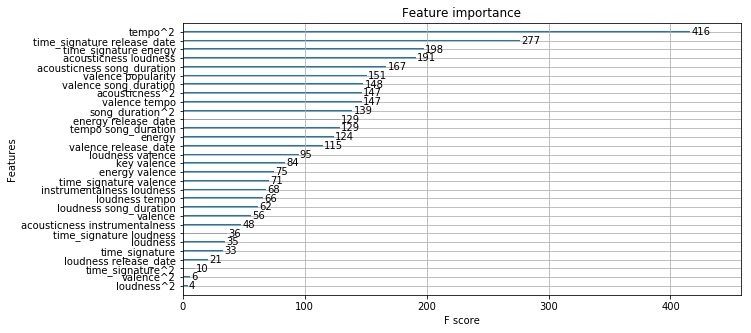

In [112]:
xgb.plot_importance(xg_clf)
plt.rcParams["figure.figsize"] = [5, 5]
plt.show()

In [117]:
# Predictions
y_train_pred_xgboost_cv = xg_clf.predict(dmatrix_spotify)

[[7055 1126  895]
 [2097 3709  140]
 [1855  168 2955]]


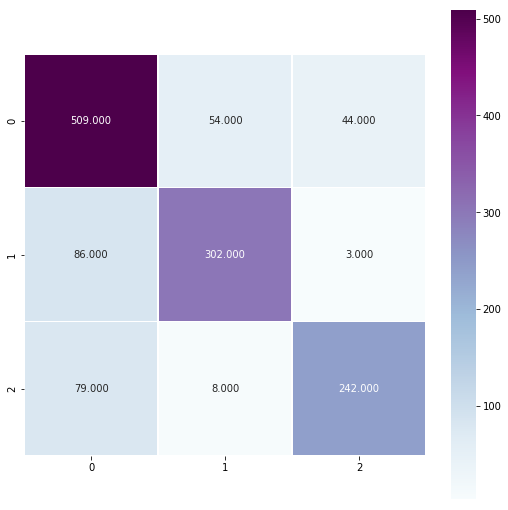

In [118]:
# Confusion Matrix
cm_xgboost_cv = confusion_matrix(Ytrain, y_test_pred_xgboost_cv)
print(cm_xgboost_cv)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_xgboost, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

# Fit Model 7: Naive Bayes

In [30]:
# Create Gaussian Classifier
gnb = GaussianNB()

In [32]:
# Fit Model 
model_gnb = gnb.fit(X_train, y_train)

In [34]:
# Predictions
y_train_pred_gnb = model_gnb.predict(X_train)
y_test_pred_gnb = model_gnb.predict(X_test)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(y_train, y_train_pred_gnb, average = "micro"))
print("Test F1 Micro Average: ", f1_score(y_test, y_test_pred_gnb, average = "micro"))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred_gnb))

Training F1 Micro Average:  0.4319492339872237
Test F1 Micro Average:  0.4331128573312982
Test Accuracy:  0.4331128573312982


[[ 4948 15662  3564]
 [ 1728 12973  1134]
 [ 4174  3821  5063]]


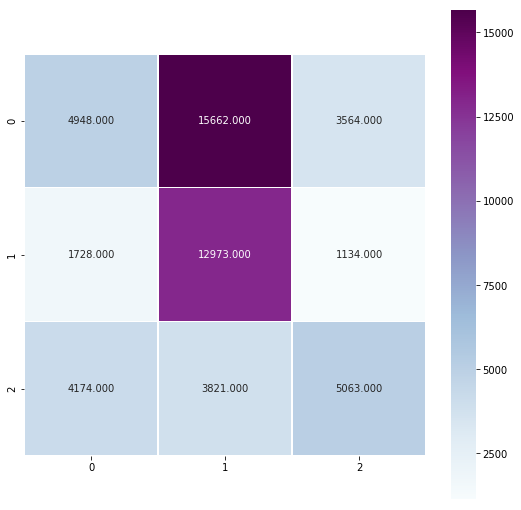

In [49]:
# Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_test_pred_gnb)
print(cm_gnb)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_gnb, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

In [37]:
# Classification Report
print(classification_report(y_test, y_test_pred_gnb))

              precision    recall  f1-score   support

           0       0.46      0.20      0.28     24174
           1       0.40      0.82      0.54     15835
           2       0.52      0.39      0.44     13058

   micro avg       0.43      0.43      0.43     53067
   macro avg       0.46      0.47      0.42     53067
weighted avg       0.45      0.43      0.40     53067



# Fit Model 8: Support Vector Machine

In [119]:
# Use MinMax Scaler to scale X
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit MinMax Scaler
scaler.fit(Xtrain)

# Create Scaled X
X_svm_train = scaler.transform(Xtrain)  
X_svm_test = scaler.transform(Xtest)

# Sanity check
X_svm_train = pd.DataFrame(X_svm_train, columns = X.columns)
X_svm_test = pd.DataFrame(X_svm_test, columns = X.columns)

In [124]:
# Create a svm Classifier
clf_svm = svm.LinearSVC(dual = False, random_state = 40, multi_class = "ovr", verbose = True) 

In [125]:
# Penalty Term - Regularization
C = [0.1, 0.01, 0.001]

hyperparameters = dict(C = C)

In [126]:
# Create Grid Search
svm_gs = GridSearchCV(clf_svm, hyperparameters, cv = 5, verbose = 2)

In [127]:
# Fit Tree
model_svm = svm_gs.fit(X_svm_train, Ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.6s
[CV] C=0.1 ...........................................................
[LibLinear][CV] ............................................ C=0.1, total=   0.6s
[CV] C=0.1 ...........................................................
[LibLinear][CV] ............................................ C=0.1, total=   0.6s
[CV] C=0.1 ...........................................................
[LibLinear][CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.01 ..........................................................
[LibLinear][CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[LibLinear][CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[LibLinear][CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.7s finished


In [128]:
# Model best estimators
print("Penalization Term: ", model_svm.best_estimator_.get_params()["C"])

Penalization Term:  0.1


In [131]:
# Predictions
y_train_pred_svm = model_svm.best_estimator_.predict(X_svm_train)
y_test_pred_svm = model_svm.best_estimator_.predict(X_svm_test)

# Print F1 scores
print("Training F1 Micro Average: ", f1_score(Ytrain, y_train_pred_svm, average = "micro"))
print("Test F1 Micro Average: ", f1_score(Ytest, y_test_pred_svm, average = "micro"))

Training F1 Micro Average:  0.55265
Test F1 Micro Average:  0.5545714285714286


[[2354  512  332]
 [1155  774   99]
 [ 938   82  754]]


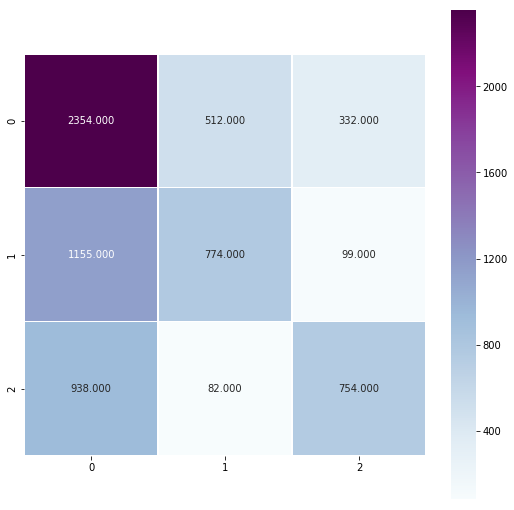

In [133]:
# Confusion Matrix
cm_svm = confusion_matrix(Ytest, y_test_pred_svm)
print(cm_svm)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_svm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "BuPu")
plt.show()

In [134]:
# Classification Report
print(classification_report(Ytest, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.53      0.74      0.62      3198
           1       0.57      0.38      0.46      2028
           2       0.64      0.43      0.51      1774

   micro avg       0.55      0.55      0.55      7000
   macro avg       0.58      0.51      0.53      7000
weighted avg       0.57      0.55      0.54      7000

